# Automating the hydrological Analysis Using Python

### Importing needed modules


In [1]:
import warnings
import numpy as np
import pysheds
import seaborn as sns
import warnings
import pandas as  pd
warnings.filterwarnings('ignore')
sns.set_palette('husl')



## reading DEM data


In [2]:
from pysheds.grid import Grid
grid =Grid.from_raster(r'C:\Users\Ism\Downloads\dem.Tif',data_name='dem')
dem = grid.read_raster(r'C:\Users\Ism\Downloads\dem.Tif')




### visualizing the Digital Elevation model



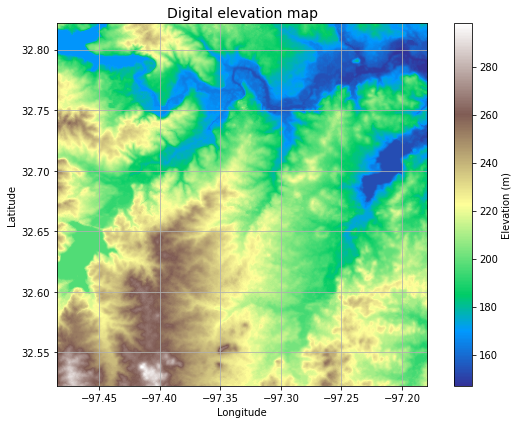

In [3]:
# plotting code
import matplotlib.pyplot as plt
from matplotlib import colors

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()


In [4]:
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)


### Elevation of the flow direction

#### Specify flow direction values According to the different directions.

N    NE    E    SE    S    SW    W    NW

In [5]:
          #N  NE    E    SE   S  SW    W    NW
dirmap = (64, 128,  1,   2,   4,  8,   16,  32)
# the inflated_dem is the dem after filling all pits , depressions and flats
fdir =  grid.flowdir(inflated_dem, dirmap=dirmap)


## Plotting the Flow Direction

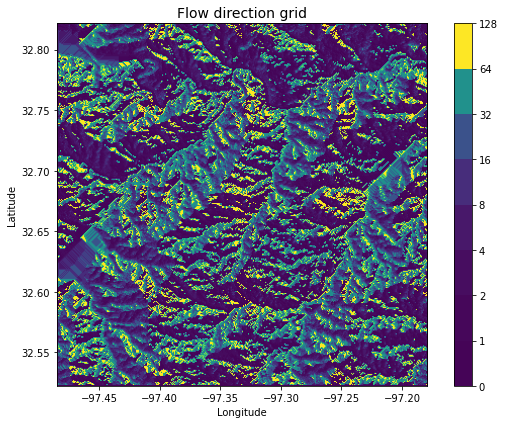

In [6]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()
plt.show()

### Computing Accumalation of flow from the flow direction

In [7]:
acc = grid.accumulation(fdir, dirmap=dirmap,apply_mask=True)
# fdir is the flow direction

### Ploting the Flow Accumlation

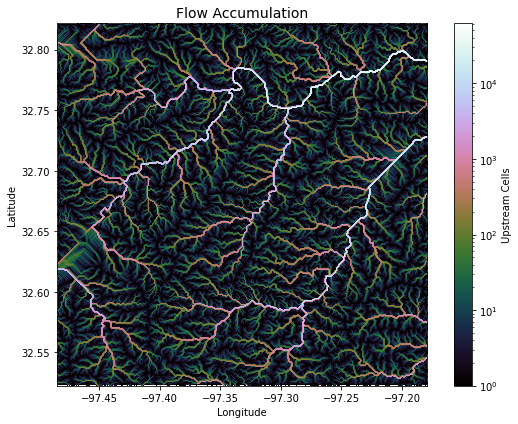

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

### Obtaining Stream Order


### Important Note
#### We can change the geometry of the returned river network by specifying different accumulation thresholds:
###### I choosed it to be 1500

In [9]:

branches = grid.extract_river_network(fdir, acc >1500, dirmap=dirmap)


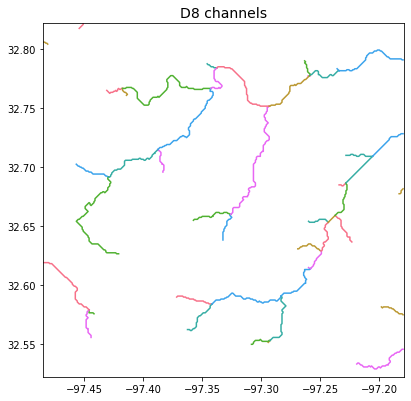

In [10]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)


### After getting the branches of flow over 1500, I need to select the pour points for start Delinating catchment from flow direction , But I am facing a problem that I have an image plot which make it difficult for extracting the the coordinates of the pour points

##### I solved this issue by extracting the x and y values of every point in the previous visualization , then I will use ploty for building and interactive dashboard for getting x and y for all the pour points.

In [11]:

final_list=[]
x_coordinates=[]
y_coordinates=[]
for i in branches['features']:
    for j in i["geometry"]['coordinates']:
        final_list.append(j)
for i in final_list:
    x_coordinates.append(i[0])
    y_coordinates.append(i[1])

    

In [12]:
import plotly.express as px
fig=px.scatter(x=x_coordinates,y=y_coordinates, height=500,width=800)
fig.show()


### delinate watershed for only one pour point by doing it manually and inputting x,y coordinates of only one point

In [13]:
x, y = -97.32417, 32.665

# Snapping pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1500, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')


# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)


Text(0.5, 1.0, 'Delineated Catchment')

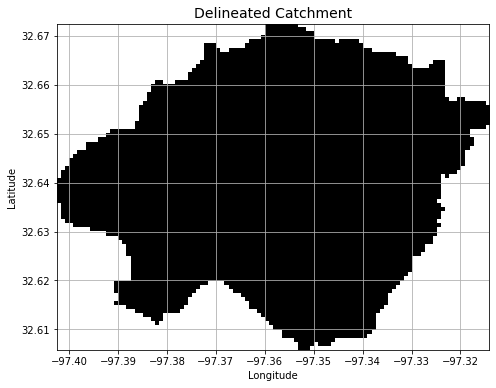

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)


## In progress
### Creating a mouse event to extract the x_coordinates,Y_coordinates of pour points by clicking on the point in the visualization for  Having a list for all pour points in order to be used for automating watersheds delination